In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

import nltk
nltk.download('stopwords')
import numpy as np
import pandas as pd
from gensim.models.keyedvectors import KeyedVectors
import gc
import math
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from smart_open import open
from nltk.corpus import stopwords
from sklearn.metrics import classification_report
from keras.layers import Dropout
from matplotlib import pyplot as plt

dev_location = "dev_data"
test_location = "test_data"
train_location = "train_data"

devData = np.array(pd.read_csv('/content/drive/My Drive/diacwoz/dev_split_Depression_AVEC2017.csv',delimiter=',',encoding='utf-8'))[:, 0:2]
testData = np.array(pd.read_csv('/content/drive/My Drive/diacwoz/full_test_split.csv',delimiter=',',encoding='utf-8'))[:, 0:2]
trainData = np.array(pd.read_csv('/content/drive/My Drive/diacwoz/train_split_Depression_AVEC2017.csv',delimiter=',',encoding='utf-8'))[:, 0:2]

dataset = np.concatenate((devData, np.concatenate((testData, trainData))))

gc.collect()      
model = KeyedVectors.load_word2vec_format('/content/drive/My Drive/GoogleNews-vectors-negative300.bin', binary=True)
stop_words = set(stopwords.words('english'))

Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [2]:
def patient_id_check(patientID, split):
  for i in split:
    if(patientID == i[0]):
      return True
  return False

def load_text(patientID, location):
  #print("PatientID: " + str(int(patientID)))
  p_id = [int(patientID)]
  text_Dim = load_text_data(patientID, location)
  text_Dim = np.array(text_Dim)

  return text_Dim

def load_text_data(patientID, location):
  fileName = "/content/drive/My Drive/diacwoz/"+ str(location) + "/" + str(int(patientID)) + "_TRANSCRIPT.csv"
  file = np.array(pd.read_csv(fileName,delimiter='\t',encoding='utf-8', engine='python'))
  outputList = []

  for i in range(len(file)):
    line = file[i][3]
    words = str(line).split(" ")
    char_count_tot = 0
    for word in words: 
      char_count_tot += len(word)

    line_s = file[i][0] 
    line_e = file[i][1]
    speaker = file[i][2]
    if speaker == 'Ellie':
      continue
    else:
      speaker = 1

    totalTime = line_e - line_s
    sec_cha = totalTime/char_count_tot

    w_s = line_s
    for word in words:
      w_e = w_s + (sec_cha * len(word))
      appender = [w_s, w_e, speaker]
      vector = list(vec(word))
      for v in vector:
        appender.append(v)
      outputList.append(appender)
      w_s = w_e

  return outputList

def remove_StopWords(line):
    filtered_sentence = [] 
    for w in line: 
        if w not in stop_words: 
            filtered_sentence.append(w)
    return filtered_sentence

def vec(word):
  word = str(word)
  try:
    if word[0] == '<':
        word = word[1:]
    if word[-1] == '>':
        word = word[0:-1]
  except:
    gab = 3
  if(word in model):
      return np.array(model[word])
  else:
    return np.zeros((300))


Ytrain = []
Ytest = []
text_train = []
text_test = []


lengths = []
for datapoint in dataset:
  if(patient_id_check(datapoint[0], devData)):

    datapoint in devData
    text = load_text(datapoint[0], dev_location)
    text = text[:,2:]
    text_train.append(text)
    Ytrain.append(datapoint[1])
  if(patient_id_check(datapoint[0], testData)):
    text = load_text(datapoint[0], test_location)
    text = text[:,2:]
    text_test.append(text)
    Ytest.append(datapoint[1])
  elif(patient_id_check(datapoint[0], trainData)):
    text = load_text(datapoint[0], train_location)
    text = text[:,2:]
    text_train.append(text)
    Ytrain.append(datapoint[1])
model = []
gc.collect()


def vec_length_corr(arr, size):
  temp = arr[0:min(len(arr),size), :]
  if (len(temp) < size):
    temp = np.concatenate((temp, np.zeros(((size - len(temp)), arr.shape[1]))), axis = 0 )
  return temp

tot_lines = 1700

for i in range(len(text_train)):
  text_train[i] = vec_length_corr(text_train[i], tot_lines)

for i in range(len(text_test)):
  text_test[i] = vec_length_corr(text_train[i], tot_lines)

text_test = np.array(text_test)

text_train = np.array(text_train)

gc.collect()

print(text_test.shape)
print(text_train.shape)

dataset = []
devData = []
trainData = []
testdata = []
gc.collect()

Ytrain = np.array(Ytrain)
Ytest = np.array(Ytest)

gc.collect()

import sklearn
from sklearn import preprocessing

def upsample(X_train,Y_train):
  X_train_0 = X_train[Y_train==0]
  X_train_1 = X_train[Y_train==1]

  Y_train_1 = Y_train[Y_train==1]
  size = X_train_0.shape[0] - X_train_1.shape[0]
  X = []
  Y = []
  X_train = list(X_train)
  Y_train = list(Y_train)
  while(size>0):
    size -= 1
    index = np.random.randint(0,X_train_1.shape[0]-1)
    leave_index = np.random.randint(0,len(X_train)-1)
    X_add = X_train_1[index]
    X_leave = X_train[leave_index]

    Y_add = Y_train_1[index]
    Y_leave = Y_train[leave_index]

    X_train[leave_index] = X_add
    X_train.append(X_leave)

    Y_train[leave_index] = Y_add
    Y_train.append(Y_leave)


  X_train = np.array(X_train)
  Y_train = np.array(Y_train)
  return X_train,Y_train


text_train = np.nan_to_num(text_train)


text_train, Ytrain = upsample(text_train,Ytrain)

gc.collect()

for i in range(text_train.shape[0]):
  text_train[i] = sklearn.preprocessing.normalize(text_train[i])


text_test = np.nan_to_num(text_test)


for i in range(text_test.shape[0]):
  text_test[i] = sklearn.preprocessing.normalize(text_test[i])

(47, 1700, 301)
(142, 1700, 301)


In [5]:

import tensorflow as tf

from tensorflow import keras

from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras import layers

import numpy as np

class Highway(layers.Layer):

  def __init__(self):
    super(Highway, self).__init__()

  def build(self, input_shape):
    n_sentences = input_shape[1]
    n_features = input_shape[2]
    carry_bias = keras.initializers.Constant(value=-1.0)
    random_dist = keras.initializers.RandomNormal(mean=0.0, stddev=0.1)

    carry_bias_2 = keras.initializers.Constant(value= 0.1)

    self.W_T = self.add_weight(shape=(n_features, n_features),initializer = random_dist,trainable=True)
    self.b_T = self.add_weight(shape=( n_sentences, n_features),initializer = carry_bias, trainable=True)
   
    self.W = self.add_weight(shape=( n_features, n_features),initializer = random_dist, trainable=True)
    self.b = self.add_weight(shape=( n_sentences, n_features),initializer = carry_bias_2, trainable=True)


  def call(self, inputs):
    x = inputs
    T = tf.sigmoid(tf.matmul(x, self.W_T) + self.b_T, name="transform_gate")
    H = tf.nn.relu(tf.matmul(x, self.W) + self.b, name="activation")
    C = tf.subtract(1.0, T, name="carry_gate")
    
    return tf.add(tf.multiply(H, T), tf.multiply(x, C), "y")


# Multiple Inputs
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import concatenate


input3 = Input(shape = (1700,301), name = 'Text_input')

highway2 = Highway()(input3)
highway3 = Highway()(highway2)
dense6 = Dense(903)(highway3)
dense3 = Dense(452)(dense6)
dense2 = Dense(55)(dense3)
# merge input models dense 2 output is connected to input
merge = concatenate([dense2], axis = 1)
# interpretation model
lstm = LSTM(128, dropout = 0.2, recurrent_dropout = 0.2)(merge)
output = Dense(1, activation='sigmoid')(lstm)
model = Model(inputs=[ input3], outputs=output)
# summarize layers
print(model.summary())
# plot graph
plot_model(model)
optimizer = tf.keras.optimizers.Adam(learning_rate= 0.0001)
model.compile(optimizer=optimizer, loss='binary_crossentropy')

model.fit([text_train],Ytrain, validation_split = 0.2, callbacks = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=15, verbose=0, mode='min',
    baseline=None, restore_best_weights=True),epochs=50, batch_size = 2)





def Thresholding(Y_pred, threshold):
  Y_pred2 = []
  print("Y_pred: ", Y_pred.shape)
  for i in range(len(Y_pred)):
    if(Y_pred[i] < threshold):
      Y_pred2.append(0)
    else:
      Y_pred2.append(1)

  return np.array(Y_pred2)


from sklearn.metrics import classification_report
pred = model.predict([text_test])
pred2 = model.predict([text_train])


print(classification_report(Ytest,Thresholding(pred,0.5)))
print("TRAINING ACCCCCC        " , classification_report(Ytrain,Thresholding(pred2,0.5)))

print(classification_report(Ytest,Thresholding(pred,0.6)))

print(classification_report(Ytest,Thresholding(pred,0.4)))
print(classification_report(Ytest,Thresholding(pred,0.3)))
print(classification_report(Ytest,Thresholding(pred,0.7)))
print(classification_report(Ytest,Thresholding(pred,0.8)))




/usr/local/lib/python3.9/dist-packages/keras/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Text_input (InputLayer)     [(None, 1700, 301)]       0         
                                                                 
 highway_4 (Highway)         (None, 1700, 301)         1204602   
                                                                 
 highway_5 (Highway)         (None, 1700, 301)         1204602   
                                                                 
 dense_7 (Dense)             (None, 1700, 903)         272706    
                                                                 
 dense_8 (Dense)             (None, 1700, 452)         408608    
                                                                 
 dense_9 (Dense)             (None, 1700, 55)          24915     
                                                                 
 concatenate_2 (Concatenate)  (None, 1700, 55)         0   

In [ ]:
print(classification_report(Ytest,Thresholding(pred,0.95)))

Y_pred:  (47, 1)
              precision    recall  f1-score   support

         0.0       0.75      0.91      0.82        33
         1.0       0.57      0.29      0.38        14

    accuracy                           0.72        47
   macro avg       0.66      0.60      0.60        47
weighted avg       0.70      0.72      0.69        47



In [ ]:
test_pred = [[9.0,9.0]]
x1 = np.zeros(len(Ytest))
x2 = np.zeros(len(Ytest))
y1 = np.zeros(len(Ytest))
y2 = np.zeros(len(Ytest))
for i in range(len(Ytest)):
  i_lo = [[Ytest[i],pred[i][0]]]
  x1[i] = i+1
  x2[i] = i+1
  if Ytest[i] == 0:
    y1[i] = pred[i][0]
  else:
    y2[i] = pred[i][0]
  test_pred = np.append(test_pred,i_lo,axis=0)

test_pred = np.delete(test_pred, 0, 0)
print(test_pred)

[[0.         0.39657122]
 [0.         0.01826781]
 [0.         0.39657131]
 [1.         0.39657122]
 [1.         0.98938483]
 [1.         0.99864918]
 [0.         0.99915409]
 [0.         0.40109462]
 [0.         0.39657122]
 [1.         0.39657122]
 [0.         0.39657122]
 [1.         0.39657122]
 [0.         0.39657122]
 [1.         0.39657122]
 [1.         0.39657122]
 [0.         0.39657122]
 [1.         0.98969084]
 [0.         0.39657122]
 [0.         0.39637893]
 [1.         0.39657122]
 [0.         0.99351573]
 [0.         0.39657122]
 [0.         0.75035816]
 [1.         0.99132949]
 [0.         0.02811581]
 [0.         0.39657122]
 [1.         0.39657122]
 [0.         0.39657122]
 [1.         0.01211242]
 [0.         0.01008352]
 [0.         0.98548746]
 [0.         0.39657122]
 [0.         0.39657122]
 [0.         0.39657122]
 [0.         0.39657122]
 [0.         0.02250539]
 [0.         0.39657122]
 [1.         0.04139025]
 [1.         0.39657122]
 [0.         0.39657122]


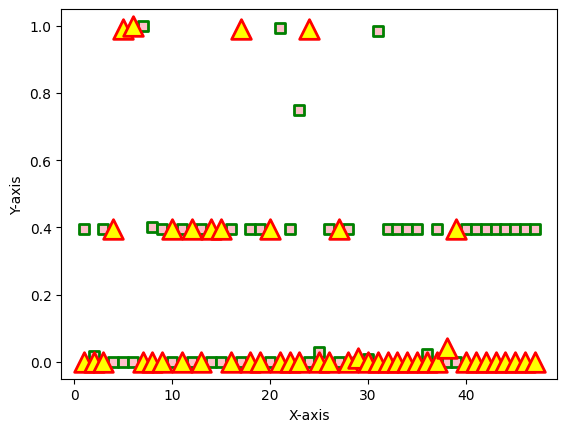

In [ ]:

import matplotlib.pyplot as plt

plt.scatter(x1, y1, c ="pink",
            linewidths = 2,
            marker ="s",
            edgecolor ="green",
            s = 50)
 
plt.scatter(x2, y2, c ="yellow",
            linewidths = 2,
            marker ="^",
            edgecolor ="red",
            s = 200)
 
plt.xlabel("X-axis")
plt.ylabel("Y-axis")
plt.show()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

newData = pd.read_excel('/content/drive/MyDrive/AI ML/logisctic.xlsx')

x = newData.iloc[:, [3]].values
y = newData.iloc[:, 1].values

print(x)
print(y)

[[0.45002955]
 [0.46505043]
 [0.45002952]
 [0.45002952]
 [0.60440147]
 [0.47515643]
 [0.41103938]
 [0.45003659]
 [0.45002952]
 [0.45002955]
 [0.45002952]
 [0.45002952]
 [0.45002955]
 [0.45002955]
 [0.45002955]
 [0.45002955]
 [0.51328653]
 [0.45002952]
 [0.45002002]
 [0.45002955]
 [0.43602717]
 [0.45002955]
 [0.46004692]
 [0.70302463]
 [0.52240366]
 [0.45002952]
 [0.45002952]
 [0.45002955]
 [0.38980383]
 [0.39151099]
 [0.4381611 ]
 [0.45002955]
 [0.45002952]
 [0.45002952]
 [0.45002952]
 [0.37414137]
 [0.45002952]
 [0.37380275]
 [0.45002952]
 [0.45002955]
 [0.45002952]
 [0.45002955]]
[0 0 0 1 1 1 0 0 0 1 0 1 0 1 1 0 1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 0
 1 1 0 0 0]


In [ ]:

  
xtrain, xtest, ytrain, ytest = train_test_split(
    x, y, test_size=0.4, random_state=42)

classifier = LogisticRegression(random_state = 0)
classifier.fit(xtrain, ytrain)

y_pred = classifier.predict(xtest)
print(ytrain, ytest)

[0 0 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 1 1] [0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 1]


In [ ]:

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score


  
cm = confusion_matrix(ytest, y_pred)
print ("Confusion Matrix : \n", cm)



  
print ("Accuracy : ", accuracy_score(ytest, y_pred))
print ("F1 : ", f1_score(ytest, y_pred))

print(ytest, y_pred)

Confusion Matrix : 
 [[11  0]
 [ 6  0]]
Accuracy :  0.6470588235294118
F1 :  0.0
[0 1 0 1 1 0 1 0 0 0 0 0 0 1 0 0 1] [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
